In [1]:
from pathlib import Path

import PIL
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision.datasets import ImageFolder

import normflows as nf

The dataset is subset of [Places365 Standard dataset](http://places2.csail.mit.edu/download-private.html). Each images was cropped to square and then rescaled to 32x32. It's very small subset, so the training is quick. The point of this notebook is not to train a good model, but to show the problem with values jumping to infinity, during sampling.

In [2]:
TRAINVAL_DIR = Path('/mnt/arch_data/datasets/inz_small')

In [3]:
!tree -d '/mnt/arch_data/datasets/inz_small'

/mnt/arch_data/datasets/inz_small
├── forest
├── mountains
└── water

4 directories


In [4]:
orig_img_ds = ImageFolder(TRAINVAL_DIR)
print(len(orig_img_ds))

2135


# 1) Viewing exemplary images from dataset

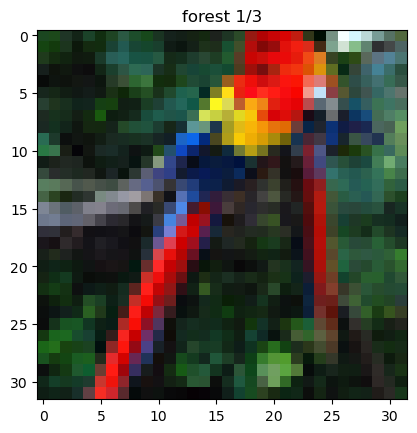

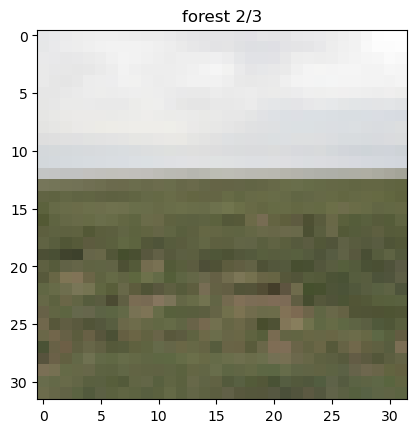

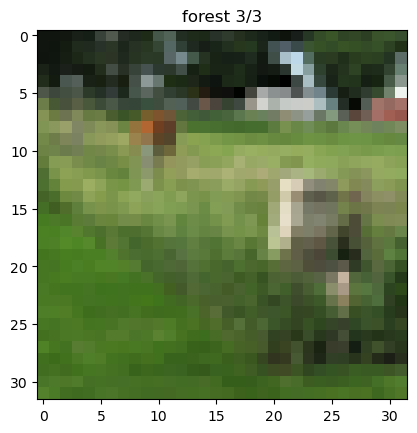

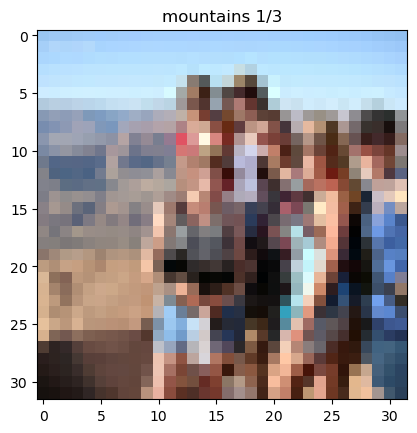

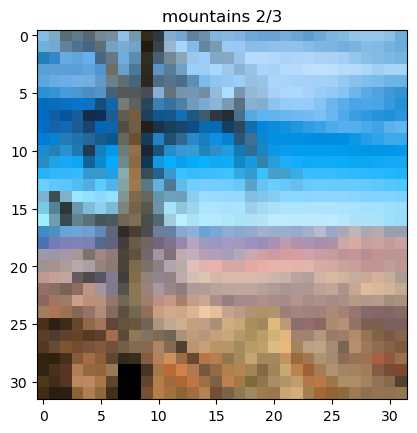

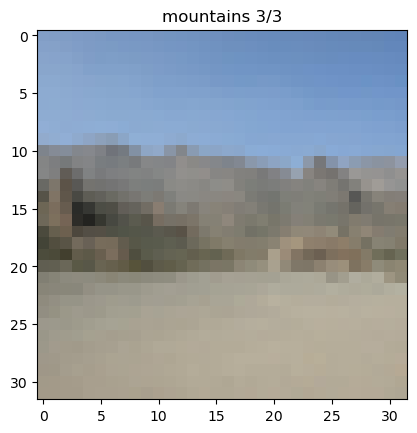

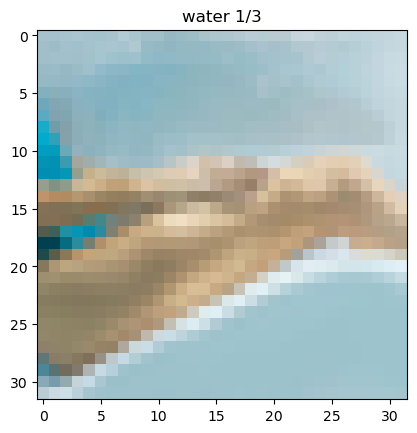

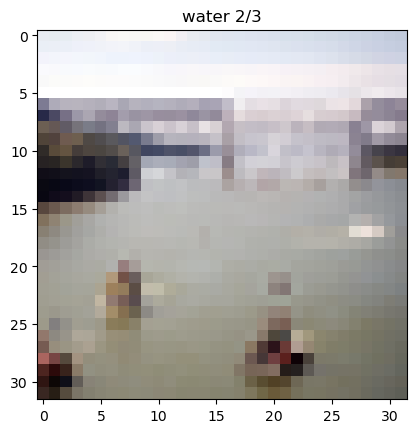

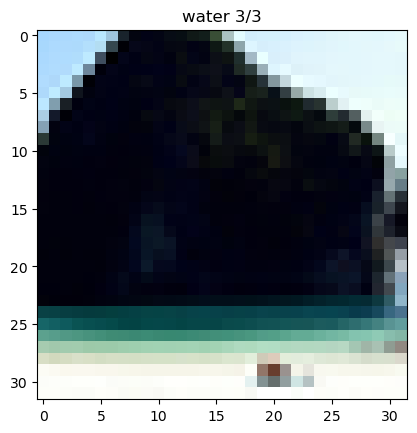

In [5]:
N = 3
for class_name, class_idx in orig_img_ds.class_to_idx.items():
    for i in range(N):
        img, label = orig_img_ds[np.random.randint(0, len(orig_img_ds))]
        while label != class_idx:
            img, label = orig_img_ds[np.random.randint(0, len(orig_img_ds))]
        
        plt.imshow(np.array(img), vmin=0, vmax=255)
        plt.title(f"{class_name} {i+1}/{N}")
        plt.show()

### Crating a model
The below function creates the model. It is identical to the one used in [this notebook](https://github.com/VincentStimper/normalizing-flows/blob/master/examples/glow_colab.ipynb).

In [6]:
def get_glow_model():
    # Set up model

    # Define flows
    L = 3
    K = 16
    torch.manual_seed(0)

    input_shape = (3, 32, 32)
    n_dims = np.prod(input_shape)
    channels = 3
    hidden_channels = 256
    split_mode = 'channel'
    scale = True
    num_classes = 3

    # Set up flows, distributions and merge operations
    q0 = []
    merges = []
    flows = []
    for i in range(L):
        flows_ = []
        for j in range(K):
            flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                        split_mode=split_mode, scale=scale)]
        flows_ += [nf.flows.Squeeze()]
        flows += [flows_]
        if i > 0:
            merges += [nf.flows.Merge()]
            latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i), 
                            input_shape[2] // 2 ** (L - i))
        else:
            latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L, 
                            input_shape[2] // 2 ** L)
        q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]


    # Construct flow model with the multiscale architecture
    model = nf.MultiscaleFlow(q0, flows, merges)
    return model

The below function generates an images using the glow model. It works the same as 'sample' method of MultiscaleFlow (see [this file](https://github.com/VincentStimper/normalizing-flows/blob/c6616b1a9f04c0e894b9e045e66bd504db17ef5e/normflows/core.py), line 553  to 586), but it also prints how range of z changes through layers.

In [7]:
def sample(model: nf.MultiscaleFlow):
    for i in range(len(model.q0)):
        print(f'\n\n\n--------------------------------\ni={i}')
        z_, _ = model.q0[i](1)
        print(f'drawing from q[{i}], z_ range: [{z_.min().item()}, {z_.max().item()}]')

        if i == 0:
            z = z_

        else:
            z, _ = model.merges[i - 1]([z, z_])
            print(f'merging with q, z range: [{z.min().item()}, {z.max().item()}]')

        for j,glow_block in enumerate(model.flows[i][:-1]):
            affine, conv, actnorm = glow_block.flows
            part_length = len(model.flows[i])
            #----------------------------------------------------------------

            splt, aff, mrg = affine.flows

            [z1, z2], _ = splt(z)

            print(f'{aff.scale_map=}')
            param = aff.param_map(z1)
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            print(f'j {j+1}/{part_length}, scale max and min: '
                  f'{scale_.min().item()}, {scale_.max().item()}')
            scale = torch.sigmoid(scale_ + 2)
            z2 = z2 / scale + shift

            z, _ = mrg([z1,z2])

            print(f'j {j+1}/{part_length}, after affine, '
                  f'z range: [{z.min().item()}, {z.max().item()}], {z.shape=}')

            #----------------------------------------------------------------
            z, _ = conv(z)
            print(f'j {j+1}/{part_length}, after conv, '
                  f'z range: [{z.min().item()}, {z.max().item()}], {z.shape=}')
            #----------------------------------------------------------------
            z, _ = actnorm(z)
            print(f'j {j+1}/{part_length}, after actnorm, '
                  f'z range: [{z.min().item()}, {z.max().item()}], {z.shape=}')
            #----------------------------------------------------------------
        
        z, _ = model.flows[i][-1](z) # the squeeze operation

    return z

In [8]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
print(f'Using device {device}')

Using device cuda


## 1) without training
### 1.1) sampling

In [9]:
model1 = get_glow_model()
model1 = model1.to(device)
with torch.no_grad():
    img = sample(model1)

/home/jedrzej/miniconda3/envs/normflows/lib/python3.11/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /opt/conda/conda-bld/pytorch_1724789121465/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(





--------------------------------
i=0
drawing from q[0], z_ range: [-2.994307279586792, 3.026895761489868]
aff.scale_map='sigmoid'
j 1/17, scale max and min: 0.0, 0.0
j 1/17, after affine, z range: [-3.2699389457702637, 3.0546576976776123], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after conv, z range: [-3.310488700866699, 3.0825400352478027], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after actnorm, z range: [-2.5457897186279297, 2.5549004077911377], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 2/17, scale max and min: 0.0, 0.0
j 2/17, after affine, z range: [-2.825551748275757, 2.6080377101898193], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after conv, z range: [-2.731783628463745, 3.2588372230529785], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after actnorm, z range: [-2.5582633018493652, 2.6027348041534424], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 3/17, scale max and min: 0.0, 0.0
j 3/17, after affine, z range: [-2.6760334968566895, 2.9549767971038

Without any training, sampling works as it should. Values of z don't go to infinity.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4603097..3.4542656].


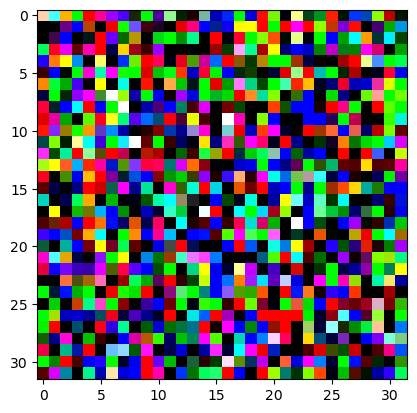

In [10]:
img = img.cpu().numpy()
img = np.transpose(img[0], (1,2,0))
plt.imshow(img, vmin=0.0, vmax=1.0)
plt.show()

As you could expect, the generated image is just random noise.

### 1.1) converting

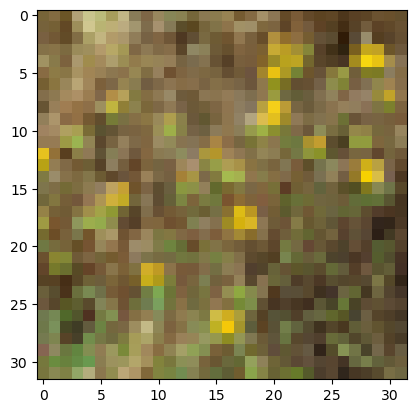

max diff is :  2.861023e-06


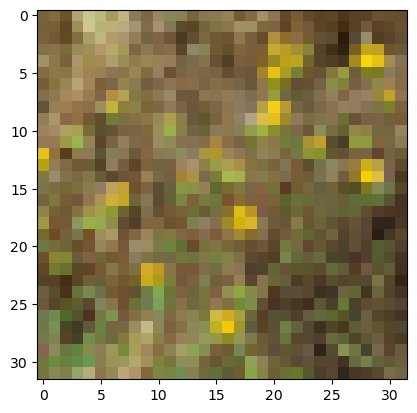

In [11]:
img = orig_img_ds[np.random.randint(0, len(orig_img_ds))][0]

plt.imshow(img)
plt.show()

img = np.transpose(np.array(img), (2,0,1))
img = img.astype(np.float32) / 255.0
img = np.reshape(img, (1, 3, 32, 32))

with torch.no_grad():
    z, _ = model1.inverse_and_log_det(torch.tensor(img).to(device))
    res_img, _ = model1.forward_and_log_det(z)
    res_img = res_img.cpu().numpy()

print('max diff is : ', np.abs(res_img - img).max())
plt.imshow(np.transpose(res_img[0], (1,2,0)), vmin=0.0, vmax=1.0)
plt.show()

Converting image to latent space and back also works.

# 2) training on 0.0 - 1.0 RGB

In [12]:
def pil_to_rgb_tensor(img: PIL.Image) -> np.ndarray:
    img = np.transpose(np.array(img), (2,0,1))
    img = img.astype(np.float32) + np.random.rand(*img.shape).astype(np.float32)
    img /= 256.0
    return torch.tensor(img)

In [13]:
dataset = ImageFolder(TRAINVAL_DIR, transform=pil_to_rgb_tensor)
img = dataset[np.random.randint(0, len(dataset))][0]
img.min().item(), img.max().item()

(0.046736616641283035, 0.8739328384399414)

Normally there whould be train and validation datasets, but the point of this notebook is not to train a good model, but to show the problem with infinity, during sampling. To make training fast, I train only for 4 epochs on very small dataset.

In [14]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

model2 = get_glow_model()
model2 = model2.to(device)
optimizer = torch.optim.Adamax(model2.parameters(), lr=1e-3, weight_decay=1e-5)

EPOCH = 4
loss_hist = []

for epoch in range(EPOCH):
    print(f'epoch {epoch+1} /{EPOCH}')
    for x,y in tqdm(train_loader):
        optimizer.zero_grad()
        loss = model2.forward_kld(x.to(device), y.to(device))
        if torch.isnan(loss) or torch.isinf(loss):
            print(f'loss is bad: {loss}')
            break
        else:
            loss.backward()
            optimizer.step()
        loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

epoch 1 /4


100%|██████████| 267/267 [00:17<00:00, 15.59it/s]


epoch 2 /4


100%|██████████| 267/267 [00:17<00:00, 15.57it/s]


epoch 3 /4


100%|██████████| 267/267 [00:17<00:00, 15.17it/s]


epoch 4 /4


100%|██████████| 267/267 [00:17<00:00, 14.98it/s]


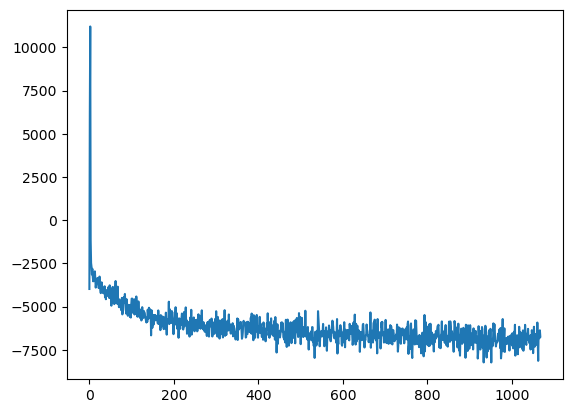

In [15]:
plt.plot(loss_hist)
plt.show()

### 2.1) Sampling

In [16]:
with torch.no_grad():
    img = sample(model2)




--------------------------------
i=0
drawing from q[0], z_ range: [-3.0099775791168213, 3.0110137462615967]
aff.scale_map='sigmoid'
j 1/17, scale max and min: -0.7412835359573364, 1.7748216390609741
j 1/17, after affine, z range: [-3.371428966522217, 3.0110137462615967], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after conv, z range: [-3.1457440853118896, 3.0786020755767822], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after actnorm, z range: [-3.2763822078704834, 3.208299398422241], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 2/17, scale max and min: -0.7888070940971375, 1.6599103212356567
j 2/17, after affine, z range: [-3.541261911392212, 3.689807891845703], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after conv, z range: [-2.8487753868103027, 3.1166486740112305], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after actnorm, z range: [-2.657766342163086, 2.94789719581604], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 3/17, scale max and min: -0.80981069803237

After training on rgb 0-1 data with noise, sampling works as it should. Values of z don't jump to infinity

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.032789826..0.98265225].


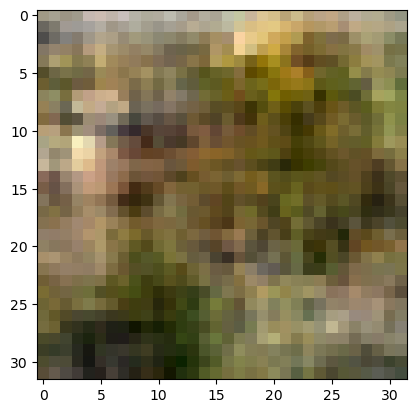

In [17]:
img = img.cpu().numpy()
img = np.transpose(img[0], (1,2,0))
plt.imshow(img, vmin=0.0, vmax=1.0)
plt.show()

### 2.1) Convertingg

1.0728836e-06


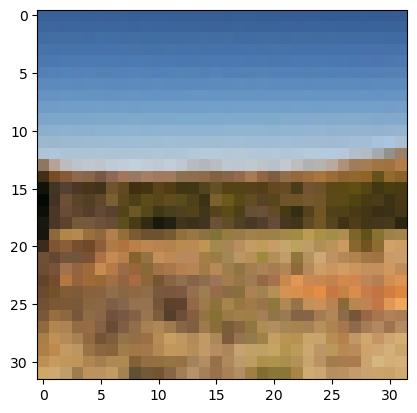

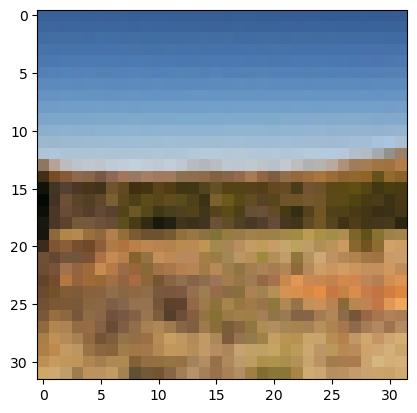

In [18]:
img = dataset[np.random.randint(0, len(dataset))][0]

with torch.no_grad():
    z, _ = model2.inverse_and_log_det(img[None].to(device))
    res_img, _ = model2.forward_and_log_det(z)

img = img.numpy()
res_img = res_img[0].cpu().numpy()

print(np.abs(res_img - img).max())
plt.imshow(np.transpose(img, (1,2,0)), vmin=0.0, vmax=1.0)
plt.show()
plt.imshow(np.transpose(res_img, (1,2,0)), vmin=0.0, vmax=1.0)
plt.show()

Converting also works.

## 3) training on hsv data
Observing sampling after training on hsv data

Below are two custom functions for converting between RGB and HSV color spaces.

While libraries like OpenCV and Pillow provide built-in functions for these conversions, they operate on 8-bit integers (values in the range 0–255) for both input and output. This can lead to a loss of information during the conversion process. Specifically, when you convert RGB to HSV and then back to RGB using these libraries, some pixel values in the resulting RGB image can differ from the original by as much as 5 or 6 units due to rounding errors and limited precision.

To address this issue, I implemented my own rgb_to_hsv and hsv_to_rgb functions. These functions work with the float64 data type, ensuring higher precision and minimizing loss of information during the conversions.

In [19]:

def rgb_to_hsv(rgb_array: np.ndarray) -> np.ndarray:
    """Converts image from rgb to hsv. The function expects input array to be of shape (H,W,3), of
    dtype np.float64 with values in range (0.0, 1.0). The output array is of shape (3,H,W) of dtype
    np.float64 and values in range (0.0, 1.0)."""

    maxc = np.max(rgb_array, axis=2)
    minc = np.min(rgb_array, axis=2)
    v = maxc
    rangec = maxc - minc
    vgr0 = maxc > 0.0
    rgr0 = rangec > 0.0
    s = np.zeros_like(v)
    s[vgr0] = rangec[vgr0] / maxc[vgr0]

    h = np.zeros_like(maxc)
    r, g, b = rgb_array[..., 0], rgb_array[..., 1], rgb_array[..., 2]
    ind = (r == maxc) & rgr0
    h[ind] = ((g[ind] - b[ind]) / rangec[ind]) % 6.0
    ind = (g == maxc) & rgr0
    h[ind] = 2.0 + ((b[ind] - r[ind]) / rangec[ind])
    ind = (b == maxc) & rgr0
    h[ind] = 4.0 + ((r[ind] - g[ind]) / rangec[ind])

    h = h / 6.0
    return np.stack([h, s, v])


def hsv_to_rgb(hsv_array: np.ndarray) -> np.ndarray:
    """Converts image from hsv to rgb. The function expects input array to be of shape (3,H,W),
    of dtype np.float64 with values in range (0.0, 1.0). The output array is of shape (H,W,3) of
    dtype np.float64 and values in range (0.0, 1.0)."""

    h, s, v = hsv_array[0], hsv_array[1], hsv_array[2]
    i = np.floor(h * 6.0)
    f = h * 6.0 - i
    i = i.astype(int)

    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    r, g, b = np.zeros_like(h), np.zeros_like(h), np.zeros_like(h)

    ind = i == 0
    r[ind] = v[ind]
    g[ind] = t[ind]
    b[ind] = p[ind]

    ind = i == 1
    r[ind] = q[ind]
    g[ind] = v[ind]
    b[ind] = p[ind]

    ind = i == 2
    r[ind] = p[ind]
    g[ind] = v[ind]
    b[ind] = t[ind]

    ind = i == 3
    r[ind] = p[ind]
    g[ind] = q[ind]
    b[ind] = v[ind]

    ind = i == 4
    r[ind] = t[ind]
    g[ind] = p[ind]
    b[ind] = v[ind]

    ind = i == 5
    r[ind] = v[ind]
    g[ind] = p[ind]
    b[ind] = q[ind]

    return np.stack([r, g, b], axis=-1)

In [20]:
def pil_to_hsv_tensor(img: PIL.Image) -> torch.Tensor:
    img = np.array(img)
    img = img.astype(np.float32) + np.random.rand(*img.shape).astype(np.float32)
    img = rgb_to_hsv(img / 256.0)
    img = torch.tensor(img)
    return img

In [21]:
dataset = ImageFolder(TRAINVAL_DIR, transform=pil_to_hsv_tensor)
img = dataset[np.random.randint(0, len(dataset))][0]
img.min().item(), img.max().item()

(0.0018943429458886385, 0.9998643398284912)

In [22]:
dataset = ImageFolder(TRAINVAL_DIR, transform=pil_to_hsv_tensor)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

model3 = get_glow_model()
model3 = model3.to(device)
optimizer = torch.optim.Adamax(model3.parameters(), lr=1e-3, weight_decay=1e-5)

EPOCH = 4
loss_hist = []

for epoch in range(EPOCH):
    print(f'epoch {epoch+1} /{EPOCH}')
    for x,y in tqdm(train_loader):
        optimizer.zero_grad()
        loss = model3.forward_kld(x.to(device), y.to(device))
        if torch.isnan(loss) or torch.isinf(loss):
            print(f'loss is bad: {loss}')
            break
        else:
            loss.backward()
            optimizer.step()
        loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

epoch 1 /4


100%|██████████| 267/267 [00:18<00:00, 14.55it/s]


epoch 2 /4


100%|██████████| 267/267 [00:19<00:00, 13.69it/s]


epoch 3 /4


100%|██████████| 267/267 [00:19<00:00, 13.93it/s]


epoch 4 /4


100%|██████████| 267/267 [00:18<00:00, 14.10it/s]


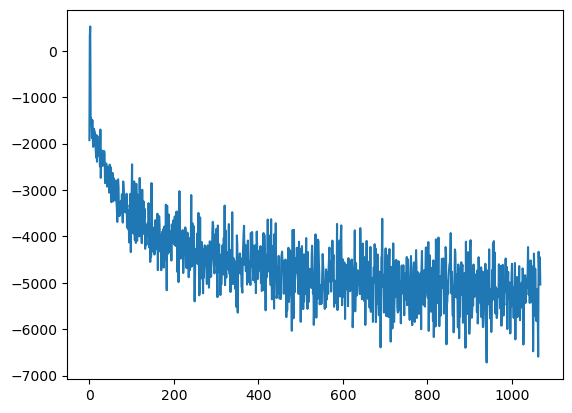

In [23]:
plt.plot(loss_hist)
plt.show()

### 3.1) Sampling

In [24]:
with torch.no_grad():
    img = sample(model3)




--------------------------------
i=0
drawing from q[0], z_ range: [-2.9691379070281982, 2.976440668106079]
aff.scale_map='sigmoid'
j 1/17, scale max and min: -0.641609251499176, 0.15095637738704681
j 1/17, after affine, z range: [-3.4190731048583984, 3.1257824897766113], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after conv, z range: [-3.2815957069396973, 3.1206717491149902], z.shape=torch.Size([1, 48, 4, 4])
j 1/17, after actnorm, z range: [-3.2901835441589355, 3.014427900314331], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 2/17, scale max and min: -0.4962654113769531, 0.3141653537750244
j 2/17, after affine, z range: [-3.2901835441589355, 3.076526641845703], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after conv, z range: [-2.817943811416626, 3.1131675243377686], z.shape=torch.Size([1, 48, 4, 4])
j 2/17, after actnorm, z range: [-2.6695523262023926, 3.4492456912994385], z.shape=torch.Size([1, 48, 4, 4])
aff.scale_map='sigmoid'
j 3/17, scale max and min: -0.62419891357

# After training on hsv data, sampling doesn't work anymore. Values jump to infiity!

3.5241246e-06


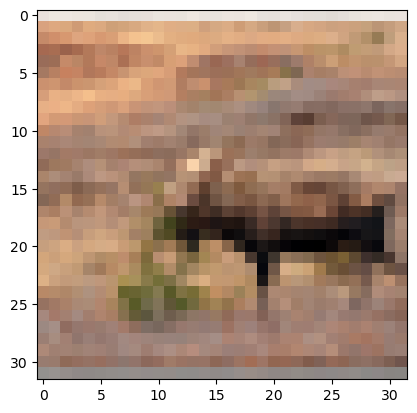

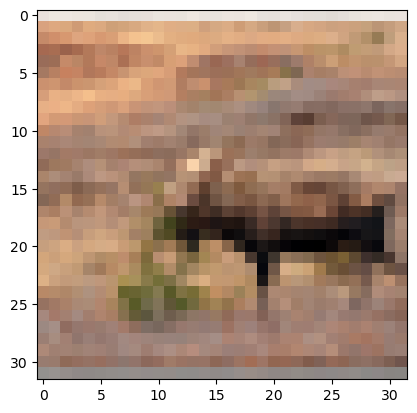

In [26]:
img = dataset[np.random.randint(0, len(dataset))][0]

with torch.no_grad():
    z, _ = model3.inverse_and_log_det(img[None].to(device))
    res_img, _ = model3.forward_and_log_det(z)

img = hsv_to_rgb(img.numpy())
res_img = hsv_to_rgb(res_img[0].cpu().numpy())

print(np.abs(res_img - img).max())
plt.imshow(img, vmin=0.0, vmax=1.0)
plt.show()
plt.imshow(res_img, vmin=0.0, vmax=1.0)
plt.show()

However, converting to latent space and back still works.